In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("outputFile.csv", parse_dates=[0])

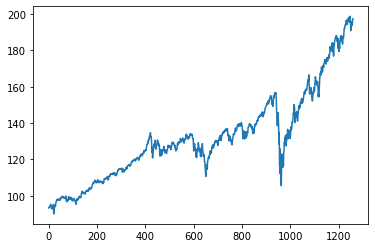

In [3]:
plt.plot(df["Adj Close"])

In [4]:
#df["Close diff"] = df["Close"] - df["Adj Close"]

In [5]:
#plt.plot(df["Close diff"])

In [6]:
#df["Close diff"].max()

In [7]:
df.head()

,Date,Adj Close
0,2016-05-25,93.288846
1,2016-05-26,93.417033
2,2016-05-27,93.736354
3,2016-05-31,93.612469
4,2016-06-01,93.758288


In [8]:
df["Close diff"] = df["Adj Close"].pct_change()

<AxesSubplot:xlabel='Close diff', ylabel='Density'>

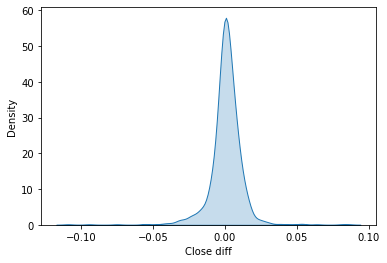

In [9]:
sns.kdeplot(data=df, x="Close diff", shade=True)

In [10]:
df["Close diff"].describe()

count    1258.000000
mean        0.000663
std         0.011544
min        -0.108919
25%        -0.003015
50%         0.000913
75%         0.005555
max         0.085919
Name: Close diff, dtype: float64

In [11]:
risk_free_rate_pa = 0.015
risk_free_daily = (1 + risk_free_rate_pa)**(1 / 365) - 1

In [12]:
#Sharpe Ratio
df["sharpe_return"] = df["Close diff"] - risk_free_daily
sharpe_ratio_daily =  df["sharpe_return"].mean() / df["sharpe_return"].std()
sharpe_ratio_yearly = df["sharpe_return"].mean() * 252 / (df["sharpe_return"].std() * np.sqrt(252))

In [13]:
print(f" Výnos pa: {df['Close diff'].mean()*252}, riziko (std): {df['Close diff'].std() * np.sqrt(252)}, sharpe ratio (p.a.): {sharpe_ratio_yearly}")

 Výnos pa: 0.16719571755643176, riziko (std): 0.1832551063218603, sharpe ratio (p.a.): 0.8562721652089119


In [14]:
df2 = df.copy()

In [15]:
df2["year"] = df2["Date"].dt.strftime('%Y')

In [16]:
df2.head()

,Date,Adj Close,Close diff,sharpe_return,year
0,2016-05-25,93.288846,NaN,NaN,2016
1,2016-05-26,93.417033,0.001374,0.001333,2016
2,2016-05-27,93.736354,0.003418,0.003377,2016
3,2016-05-31,93.612469,-0.001322,-0.001362,2016
4,2016-06-01,93.758288,0.001558,0.001517,2016


In [17]:
df2.groupby(by="year").count()

,Date,Adj Close,Close diff,sharpe_return
year,,,,
2016,153,153,152,152
2017,251,251,251,251
2018,251,251,251,251
2019,252,252,252,252
2020,253,253,253,253
2021,99,99,99,99


In [18]:
daily_return = df["Close diff"].mean()
sigma = df["Close diff"].std()
skew = df2["Close diff"].skew()
exces_kurtosis = df2["Close diff"].kurtosis()-3
params = (daily_return, sigma, skew,exces_kurtosis)

In [19]:
n_year = len(df.index)//5
return_pa = ((1+daily_return) ** n_year)-1
sigma_pa = sigma * np.sqrt(n_year)

In [20]:
sigma_pa, return_pa

(0.1828911434872663, 0.18113639530582581)

In [21]:
from scipy import stats as st

In [22]:
confidence = st.norm.ppf(.975)

In [23]:
#VaRRETURN SPACE= S√N * (-1,96 + 0,474 * μ1 / √N – 0,0687 * μ2 / N + 0,146 * μ1^2 / N) – 0,5S^2N
#VEV = √(confidence^2 – 2* VaRRETURN SPACE) -1.96 / √T

In [24]:
VARS = []
for holding in range(1,6):
    VAR_1Y = sigma * np.sqrt(n_year * holding) * (-confidence + 0.474 * skew / np.sqrt(n_year * holding) 
                                              - 0.0687 * exces_kurtosis / n_year
                                    + 0.146 * skew ** 2 / (n_year * holding)) - 0.5 * sigma ** 2 * n_year * holding
    VARS.append(VAR_1Y)

In [25]:
VARS

[-0.38092674771630874,
 -0.5464765705516698,
 -0.6773901302079477,
 -0.7903775573256184,
 -0.8919100104805855]

In [26]:
VEV = []
for position, val in enumerate(VARS):
    VEV_calc = (np.sqrt(confidence ** 2 - 2 * val) - confidence)/ np.sqrt(position + 1)
    VEV.append(VEV_calc)

In [27]:
VARS, VEV

([-0.38092674771630874,
  -0.5464765705516698,
  -0.6773901302079477,
  -0.7903775573256184,
  -0.8919100104805855],
 [0.18556912313429352,
  0.18483039279169836,
  0.18449925318845786,
  0.18430039780393637,
  0.18416392032082196])

In [28]:
#Calculate scenarios
#Unfavourable @ -10 percentile, moderate @ 50 percenile, favourable @90 percentile
#moderate = Exp [ M1*N - sigma * skew/6 – 0.5*sigma²N]

In [29]:
def calc_values(colName):
    '''
    colName = colmn name of the bootstrapped return for given scenario (unvaforable, moderate, favorable)
    '''
    for i in range(0, len(monthly_investment)):
        for j in range(i, len(monthly_investment)):
            if j > i:
                monthly_investment.iloc[j, i] = monthly_investment.iloc[j -1, i] * money_perf.loc[j, colName]

In [30]:
years = 10
initial_investment = 30000
monthly_saving = 1000

monthly_trading_days = 21


performance = pd.DataFrame(data= np.arange(0,years * 12 + 1) * monthly_trading_days, index=np.arange(0,years * 12 + 1), columns=["trading days"])

In [31]:
performance["day_mean"]=daily_return
performance["sigma"] = sigma
performance["sigma_period"] = sigma * np.sqrt(performance["trading days"])
performance["skew"] = skew
performance["exc_kurtosis"] = exces_kurtosis
performance["unfavorable_prob"] = 10
performance["moderate_prob"] = 50
performance["favorable_prob"] = 90

In [32]:
def scenario_calc(days, day_mean, sigma, skew, exc_kurt, confidence):
    '''
    days= trading days in the period
    day_mean = historical daily return
    sigma = historical daily standard deviation
    skew = historical daily skeweness
    exc_kurt = excess kurtosis (excess over 3)
    confidence = percentile 0-100
    '''
    
    #calculate z-scores
    if days == 0:
        return 1
    else:
        z = st.norm.ppf(confidence / 100)
        z1 = (z**2 - 1) / 6
        z2 = (z**3 - 3 * z) / 24
        z3 = (2 * z**3 - 5* z) / 36

        #calculate return over period
        ret = np.exp((day_mean * days) + sigma * np.sqrt(days) * (z + z1 * skew / np.sqrt(days) + z2 * exc_kurt / days
                                                         + z3 * skew**2 / days) - (0.5 * sigma**2 * days))
        return ret

In [33]:
# m = 0.0003389
# n = 1280
# sigma = 0.01224357
# skew = -0.351143435
# ekurt = 3.528503383
# scenario_calc(n, m, sigma, skew, ekurt, 50)

In [34]:
performance["moderate"] = performance[["trading days","day_mean","sigma","skew","exc_kurtosis", "moderate_prob"]].apply(lambda performance: scenario_calc(performance["trading days"], performance["day_mean"],performance["sigma"],performance["skew"], performance["exc_kurtosis"], performance["moderate_prob"]), axis=1)
performance["unfavorable"] = performance[["trading days","day_mean","sigma","skew","exc_kurtosis", "unfavorable_prob"]].apply(lambda performance: scenario_calc(performance["trading days"], performance["day_mean"],performance["sigma"],performance["skew"], performance["exc_kurtosis"], performance["unfavorable_prob"]), axis=1)
performance["favorable"] = performance[["trading days","day_mean","sigma","skew","exc_kurtosis", "favorable_prob"]].apply(lambda performance: scenario_calc(performance["trading days"], performance["day_mean"],performance["sigma"],performance["skew"], performance["exc_kurtosis"], performance["favorable_prob"]), axis=1)

In [35]:
# fig, ax = plt.subplots(figsize=(14,8))
# ax = plt.plot(performance["moderate"], color="blue")
# ax = plt.plot(performance["unfavorable"], color="red")
# ax = plt.plot(performance["favorable"], color="green")

In [36]:
money_perf = performance[["unfavorable","moderate","favorable"]].copy()

In [37]:
money_perf["unfav_bootstrap"] = money_perf["unfavorable"] / money_perf["unfavorable"].shift(1, fill_value=1)
money_perf["moderate_bootstrap"] = money_perf["moderate"] / money_perf["moderate"].shift(1, fill_value=1)
money_perf["fav_bootstrap"] = money_perf["favorable"] / money_perf["favorable"].shift(1, fill_value=1)

In [38]:
def monthly_matrix(lenght, value):
    monthly = []

    for i in range(0,lenght):
        row = []
        for j in range(0, lenght):
            if j == i and (i > 0 and i < lenght - 1):
                row.append(value)
            else:
                row.append(np.nan)   
        monthly.append(row)
    return monthly

In [39]:
scenarios = ["unfavorable","moderate", "favorable"]

for scenario in scenarios:
    
    month = np.array(monthly_matrix(len(money_perf),monthly_saving))
    month[0,0] = initial_investment

    monthly_investment = pd.DataFrame(month) 

    monthly_investment.dropna(axis=1, how="all", inplace=True)

    monthly_investment = monthly_investment / money_perf[scenario]

    monthly_investment.dropna(axis=1, how="all", inplace=True)

    if scenario == "unfavorable":
        bootstrap_name = "unfav_bootstrap"
    elif scenario == "moderate":
        bootstrap_name = "moderate_bootstrap"
    else:
        bootstrap_name = "fav_bootstrap"


    calc_values(bootstrap_name)

    money_perf[scenario + "_perf"] = monthly_investment.sum(axis=1)

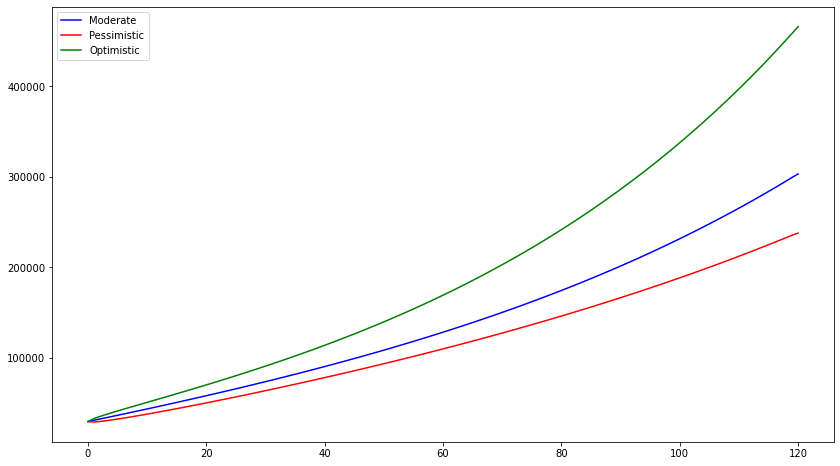

In [40]:
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(money_perf["moderate_perf"], color="blue", label="Moderate")
ax.plot(money_perf["unfavorable_perf"], color="red", label="Pessimistic")
ax.plot(money_perf["favorable_perf"], color="green", label="Optimistic")
plt.legend(loc=0)
plt.show()

In [41]:
print(f"Celkem investováno: {np.nansum(month)}\n")
print(f"Hodnota na konci období {years} let:\n")
for scenario in scenarios:
    colName = scenario + "_perf"
    value = np.round(money_perf.loc[len(money_perf)-1,colName],0)
    print(f"{scenario.capitalize()} scénář: {value} Kč")

Celkem investováno: 149000.0

Hodnota na konci období 10 let:

Unfavorable scénář: 237922.0 Kč
Moderate scénář: 303230.0 Kč
Favorable scénář: 465698.0 Kč
